In [1]:
import matplotlib.pyplot as plt
import sys, glob, re
import pyros_setup
try:
    import rospy, rosnode, rosbag
except ImportError:  # if ROS environment is not setup, we emulate it.
    pyros_setup.configurable_import().configure('mysetup.cfg').activate()  # this will use mysetup.cfg from pyros-setup instance folder
    import rospy, rosnode, rosbag
    
sys.path.append('/home/wal/catkin_ws/devel/lib/python2.7/dist-packages/') # ensure smap.msg can be found

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
import numpy as np
from matplotlib.colors import LogNorm
from decimal import *

bag = rosbag.Bag("/home/wal/catkin_ws/src/smap/stats/particles/run02.bag")
stats = None
for _, msg, _ in bag.read_messages(topics=['stats']):
    stats = msg
bag.close()
if stats is None:
    print "Stats could not be loaded."
else:
    print "Stats loaded successfully."

Re-adding /opt/ros/kinetic/lib/python2.7/dist-packages in front of sys.path
Stats loaded successfully.


In [2]:
stats.particles = np.array(stats.particles)
stats.maxStep
len(stats.particles)/3
stats.voxels
steps = stats.maxStep + 1
len(stats.particles)/steps/stats.voxels

101

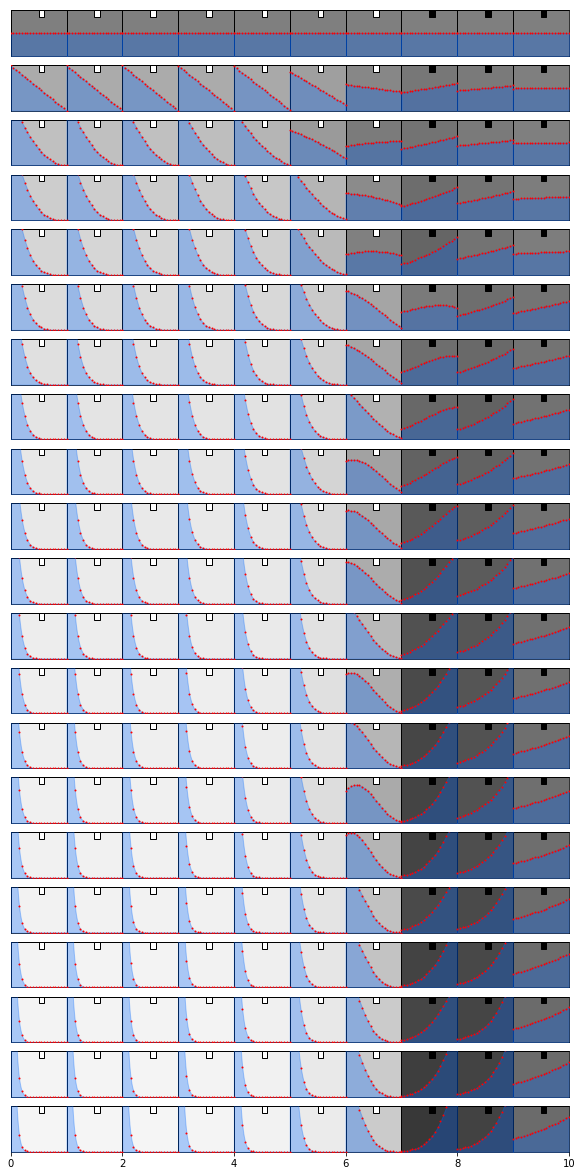

In [3]:
%matplotlib inline

# would be nice to read these values from the bag file...
x_voxels = 10 #30
y_voxels = 1 #3
z_voxels = 1

voxel_particles = len(stats.particles)/steps/stats.voxels

fig, axes = plt.subplots(steps, 1, figsize=(x_voxels, (1*steps)))
particles_per_step = len(stats.particles)/steps
for t in range(steps):
    ax = axes[t]
    particles = stats.particles[t*particles_per_step:(t+1)*particles_per_step]
    beliefMeans = stats.beliefMeans[t*stats.voxels:(t+1)*stats.voxels]
    beliefStds = stats.beliefStds[t*stats.voxels:(t+1)*stats.voxels]
    trueMeans = stats.trueMeans[t*stats.voxels:(t+1)*stats.voxels]
    i = 0
    for x in range(x_voxels):
        for y in range(y_voxels):
            for z in range(z_voxels):
                support = np.linspace(x, x+1, num=voxel_particles)
                ax.add_patch(patches.Rectangle(
                    (x, y), 1, 1,
                    facecolor="#000000",
                    alpha=beliefMeans[i]
                ))
                ax.add_patch(patches.Rectangle(
                    (x, y), 1, 1,
                    facecolor="none",
                    edgecolor="black"
                ))
                # add small hint for true occupancy
                ax.add_patch(patches.Rectangle(
                    (x+0.5, y+0.85), 0.1, 0.15,
                    facecolor=("black" if trueMeans[i] else "white"),
                    edgecolor="black"
                ))
                pys = particles[i*voxel_particles:(i+1)*voxel_particles]*50. + y
                ax.scatter(support[::5], pys[::5], c="red", s=1, zorder=20)
                pys[pys>2.1] = 2.1
                ax.fill_between(support, 0, pys, color="#0066FF", alpha=0.3, zorder=19)
                i += 1
                
    ax.set_xlim([0, x_voxels])
    ax.set_ylim([0, 1])
    if t < steps-1:
        ax.set_xticks([])
    ax.set_yticks([])

In [7]:
%matplotlib inline

from matplotlib.animation import FuncAnimation

# would be nice to read these values from the bag file...
x_voxels = 10 #30
y_voxels = 1 #3
z_voxels = 1

FRAME_RATE = 10 # intermediate frames between time steps

voxel_particles = len(stats.particles)/steps/stats.voxels

fig, ax = plt.subplots(figsize=(x_voxels, 1.6));

particles_per_step = len(stats.particles)/steps
def update(t):
    ax.clear()    
    t = min(t, steps-1)
    ax.set_xlim([0, x_voxels]);
    ax.set_ylim([0, 1]);
    ax.set_yticks([]);
    ax.set_title("$k = %i$" % t)
    particles = stats.particles[t*particles_per_step:(t+1)*particles_per_step]
    beliefMeans = stats.beliefMeans[t*stats.voxels:(t+1)*stats.voxels]
    beliefStds = stats.beliefStds[t*stats.voxels:(t+1)*stats.voxels]
    trueMeans = stats.trueMeans[t*stats.voxels:(t+1)*stats.voxels]
    i = 0
    for x in range(x_voxels):
        support = np.linspace(x, x+1, num=voxel_particles)
        for y in range(y_voxels):
            for z in range(z_voxels):
                # clear
                ax.add_patch(patches.Rectangle(
                    (x, y), 1, 1,
                    facecolor="white"
                ));
                ax.add_patch(patches.Rectangle(
                    (x, y), 1, 1,
                    facecolor="black",
                    alpha=beliefMeans[i]
                ));
                ax.add_patch(patches.Rectangle(
                    (x, y), 1, 1,
                    facecolor="none",
                    edgecolor="black"
                ));
                # add small hint for true occupancy
                ax.add_patch(patches.Rectangle(
                    (x+0.45, y+0.85), 0.1, 0.15,
                    facecolor=("black" if trueMeans[i] else "white"),
                    edgecolor="black"
                ));
                pys = particles[i*voxel_particles:(i+1)*voxel_particles]*50. + y
                ax.scatter(support[::5], pys[::5], c="red", s=1, zorder=20);
                pys[pys>2.1] = 2.1
                ax.fill_between(support, 0, pys, color="#0066FF", alpha=0.3, zorder=19);
                i += 1
    return ax

fig.set_tight_layout(True)
anim = FuncAnimation(fig, update, frames=np.arange(0, steps+7), interval=1200)
anim.save('beliefUpdate.gif', dpi=160, writer='imagemagick')
plt.close()

from IPython.display import Image
Image(url="beliefUpdate.gif")